This notebook will be used to analyze the baroclinic tides over the CODAR region.


## Background

Tidal anlaysis performed on hourly nowcast results from Nov 26, 2014- Apr 26, 2015. 

The analysis used t_tide. Scripts are found in /data/nsoontie/MEOPAR/analysis/Nancy/currents/t_tide_analysis

For each grid point in the CODAR region, the baroclinic currents $u_{bc}, v_{bc}$ were calculated as

$u_{bc}= u - u_{depav}$, 
$v_{bc} = v - v_{depav}$

where $u, v$ are the full currents at that grid point and $u_{depav}$, $v_{depav}$ are the depth avergaed currents at that grid point. Depth averaging was performed over the entire water column. 

A harmonic analysis to generate ellipse parameters for each grid point (x,y,z) was performed on $u_{bc}$ and $v_{bc}$. 

In [1]:
import datetime
import matplotlib.pylab as plt
import matplotlib.colors as mcolors
import numpy as np
import scipy.io as sio
import netCDF4 as nc

from salishsea_tools.nowcast import (research_VENUS)
from salishsea_tools import viz_tools

import baroclinic

%matplotlib inline

In [2]:
import seaborn as sns

###Load Data

In [3]:
data =sio.loadmat('/ocean/nsoontie/MEOPAR/TidalEllipseData/CODAR/CODAR_region_baroclinic_20141126_20150426.mat')
datastruc = data['datastruc']
lats = datastruc['lats'][0,0]
lons = datastruc['lons'][0,0]

grid = nc.Dataset('/data/nsoontie/MEOPAR/NEMO-forcing/grid/bathy_meter_SalishSea2.nc')

SITES = research_VENUS.SITES['VENUS']

In [4]:
#Cyclical colormap
palette = sns.hls_palette(40, l=.6, s=0.8)
cmap1 = mcolors.ListedColormap(palette)

In [5]:
def plot_ellipse_params(dep, const, datastruc, maj_lim = [0,.5], min_lim = [-.25,.25]):
    """Plots the major, minor, phase and inclination of a constituent stored in datastruc."""
    
    fig, axs = plt.subplots(2,2,figsize= (15,10))
    lonax = [-123.7,-123]
    latax= [48.8,49.3]
    
    params = baroclinic.get_constituent(const, datastruc)
    names = ['Major Axis', 'Minor Axis', 'Phase', 'Inclination']
    units = ['(m/s)', '(m/s)', '(deg GMT)', '(deg CCW East)']
    lims = [maj_lim, min_lim, [0,360], [0,180]]
    
    depth = datastruc['depth'][0,0]
    
    for param, name, unit, lim, ax in zip(params, names, units, lims, axs.flatten()):
        if name =='Phase' or name =='Inclination':
            cmap = cmap1
        else:
            cmap = 'jet'
        mesh  = ax.pcolormesh(lons, lats, param[:,:,dep], cmap=cmap, vmin=lim[0], vmax=lim[1])
        cbar = plt.colorbar(mesh, ax=ax)
        cbar.set_label('{} {}'.format(name, unit))
        ax.set_title('{0} {1} at d = {2:.3g} m'.format(const, name, depth[dep][0]))
        viz_tools.plot_coastline(ax, grid, coords = 'map')
        viz_tools.plot_coastline(ax, grid, coords = 'map', isobath = 5,color = 'grey')
        ax.set_xlim(lonax)
        ax.set_ylim(latax)
        ax.plot(SITES['Central']['lon'], SITES['Central']['lat'], 'ks', label='Central')
        ax.plot(SITES['East']['lon'], SITES['East']['lat'], 'ko',label = 'East')
        ax.legend(loc=0)
        
    return fig

In [6]:
def plot_ellipse_errors(dep, const, datastruc):
    """Plots the major, minor, phase and inclination errors of a constituent stored in datastruc."""
    
    fig, axs = plt.subplots(2,2,figsize= (15,10))
    lonax = [-123.7,-123]
    latax= [48.8,49.3]
    
    params = baroclinic.get_constituent_errors(const, datastruc)
    names = ['Major Axis', 'Minor Axis', 'Phase', 'Inclination']
    units = ['(m/s)', '(m/s)', '(deg)', '(deg)']
    
    depth = datastruc['depth'][0,0]
    cmap = 'hot'
    
    for param, name, unit,ax in zip(params, names, units, axs.flatten()):

        mesh  = ax.pcolormesh(lons, lats, param[:,:,dep], cmap=cmap)
        cbar = plt.colorbar(mesh, ax=ax)
        cbar.set_label('{} {}'.format(name, unit))
        ax.set_title('Error in {0} {1} at d = {2:.3g} m'.format(const, name, depth[dep][0]))
        viz_tools.plot_coastline(ax, grid, coords = 'map')
        viz_tools.plot_coastline(ax, grid, coords = 'map', isobath = 5,color = 'grey')
        ax.set_xlim(lonax)
        ax.set_ylim(latax)
        ax.plot(SITES['Central']['lon'], SITES['Central']['lat'], 'ks', label='Central')
        ax.plot(SITES['East']['lon'], SITES['East']['lat'], 'ko',label = 'East')
        ax.legend(loc=0)
        
    return fig

##Surface M2

/home/nsoontie/anaconda3/lib/python3.4/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/nsoontie/anaconda3/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


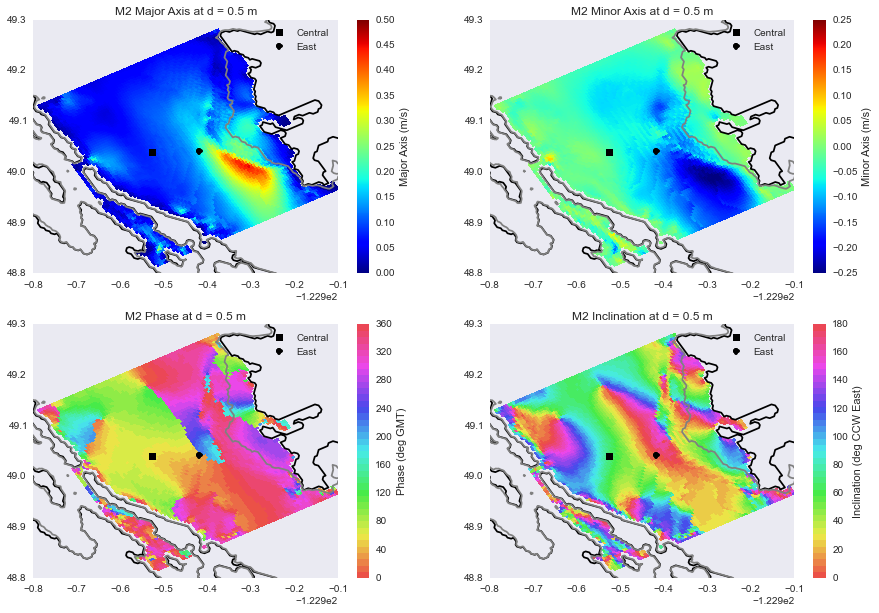

In [7]:
dep=0
fig = plot_ellipse_params(dep, 'M2', datastruc)

####Major/Minor Axis

This is really neat! There is a large M2 internal tide amplitude on the banks. Some possible explainations:
1. Internal tide generation as the currents move over the banks. If the flow is transcritcal then there can be very large waves forming at the generation site.
2. Internal tide shoaling on the banks. If the internal tide was generated else where, it could steepen and shoal as it approaches the banks. 

How can we know which mechanism is responsible for our large M2 baroclinic currents on the banks?
1. Check the phase - does it match with the barotropic tide? If so, that could indicate the large amplitude is due to internal tide generation. I will do this in detail later
2. Turn off the banks. Do we still get a large M2 signature? If so, that could indicate shoaling because the generation site is removed.
3. Compare with the CODAR. My guess is they don't see this very large signature. Remember, our surface M2 at East is a lot bigger than the CODAR. The discrepancies could be due to how the model is representing the banks. 

####Phase/Inclination
I need to do something clever with the phase and inclination. The large discontinuities in phase are associated with inlincation 'flips' since there is a 180 degree ambiguity in the inclination.

Is there a systematic way to adjust the phase and inclincation so that they don't have sharp discontinuities?? Perhaps measure phase relative to the barotropic tide phase or full tide phase?

####Notes
I did not remove the boundary layer from my depth averaging mainly because it wasn't easy to do this systematically for so many grid points. Could that contribute what we are seeing? My thinking is that if the water column is deep enough then the boundary layer won't have a big impact on the depth averaged currents. The large M2 amplitudes begin at about the 30 m isobath, which isn't exactly deep. So by not removing the boundary layer, I could be underestimating the depth averged currents and overestimating the baroclinic currents. It would be wortwhile to go back and look at the boundary layer thicnkess in this region. 

###Errors

/home/nsoontie/anaconda3/lib/python3.4/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/nsoontie/anaconda3/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


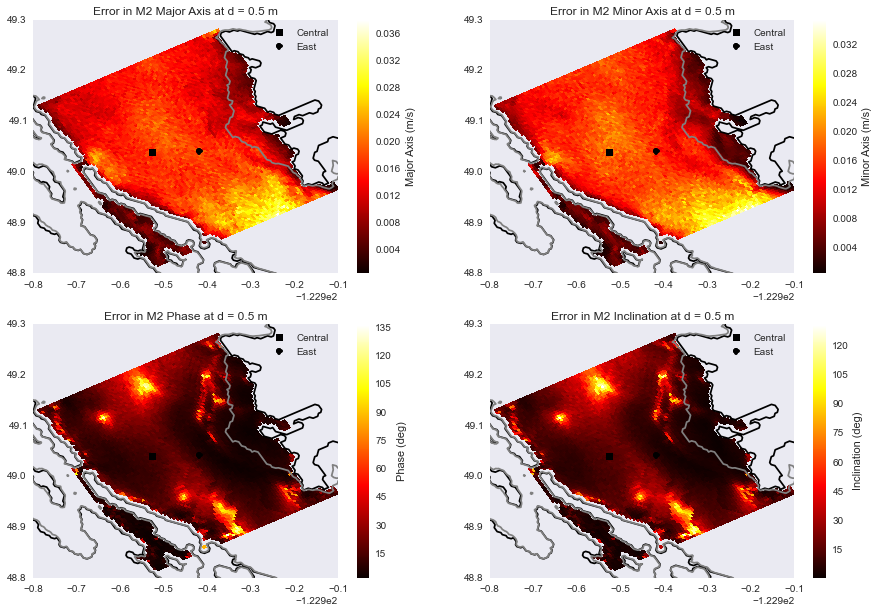

In [8]:
fig = plot_ellipse_errors(dep, 'M2', datastruc)

There are some really large errors in the phase and inlincation. The major/minor seem ok though. But why is there larger error near the south-eastern edge?

##K1 Surface

/home/nsoontie/anaconda3/lib/python3.4/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/nsoontie/anaconda3/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


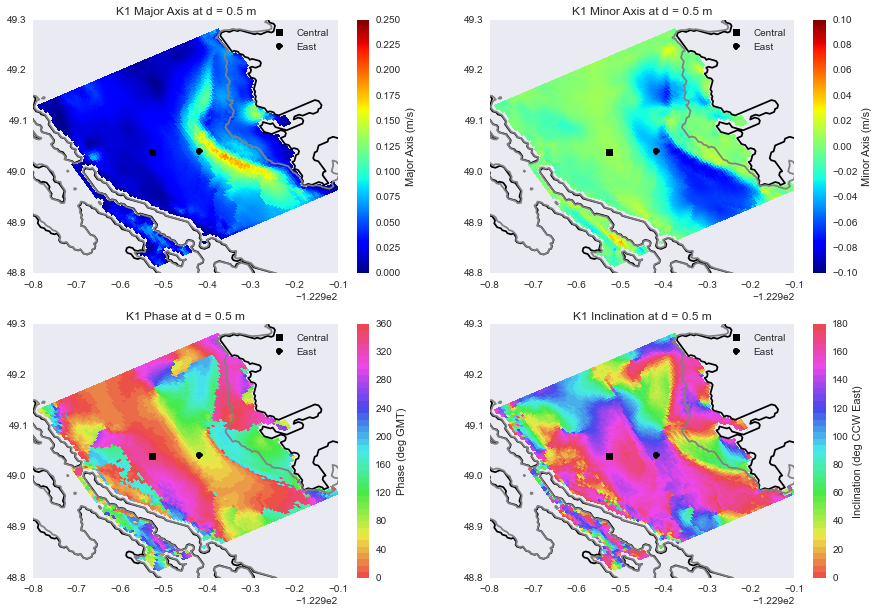

In [9]:
dep=0
fig = plot_ellipse_params(dep, 'K1', datastruc, maj_lim=[0,.25], min_lim = [-.1,.1])

K1 also has a relatively large baroclinic amplitude at the banks. I don't think this supports the shoaling theory becuse $\omega_{K1} < f$ and internal waves need $f < \omega < N$. So there cannot be an internal tide at the K1 frequency propagating through the domain and shoaling onto the banks. 

###Errors

/home/nsoontie/anaconda3/lib/python3.4/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/nsoontie/anaconda3/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


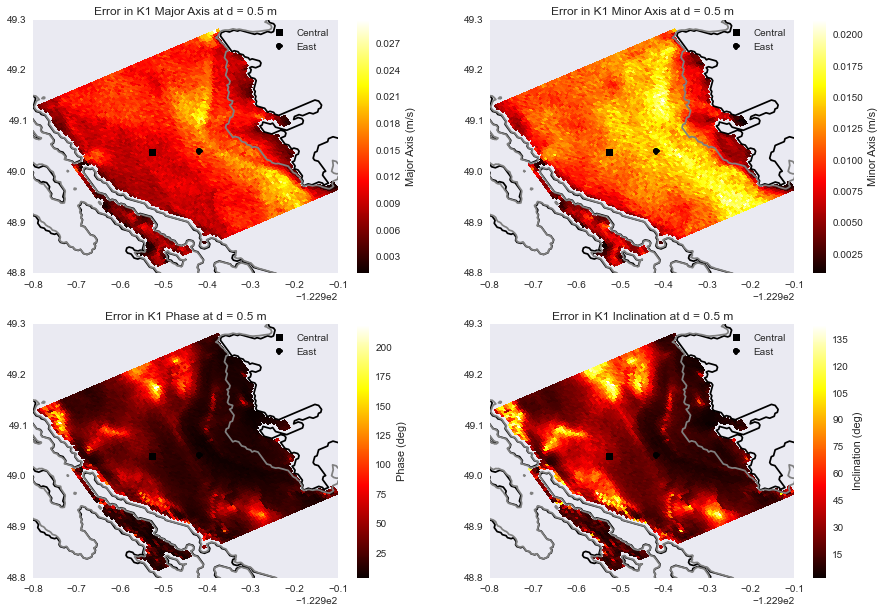

In [10]:
fig = plot_ellipse_errors(dep, 'K1', datastruc)

##M2 147m

In the baroclinic profiles at the Central nodes, there was a spike in M2 currents at 150m depth. Let's look at the depth.

/home/nsoontie/anaconda3/lib/python3.4/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/nsoontie/anaconda3/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


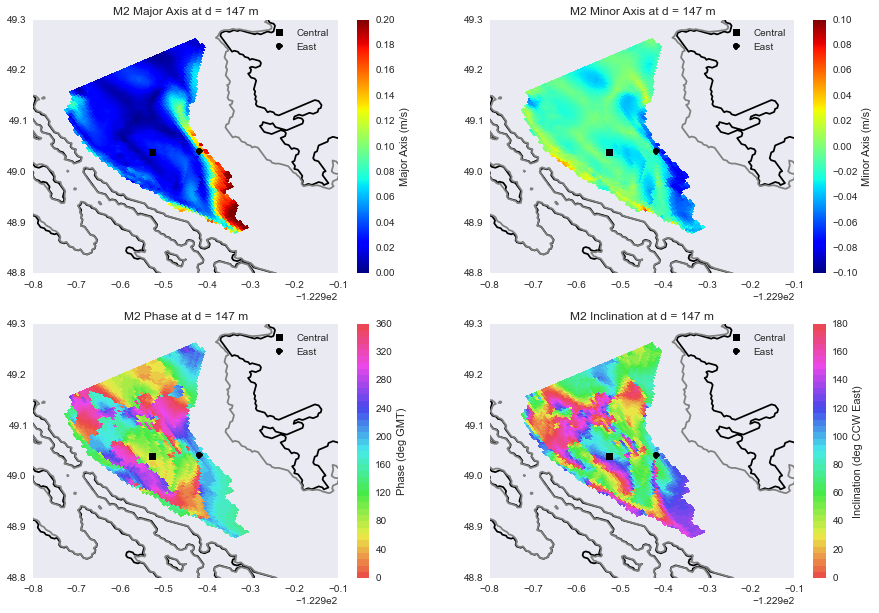

In [11]:
dep=28
fig = plot_ellipse_params(dep, 'M2', datastruc, maj_lim = [0,.2], min_lim = [-.1,.1])

##K1 147m

/home/nsoontie/anaconda3/lib/python3.4/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/nsoontie/anaconda3/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


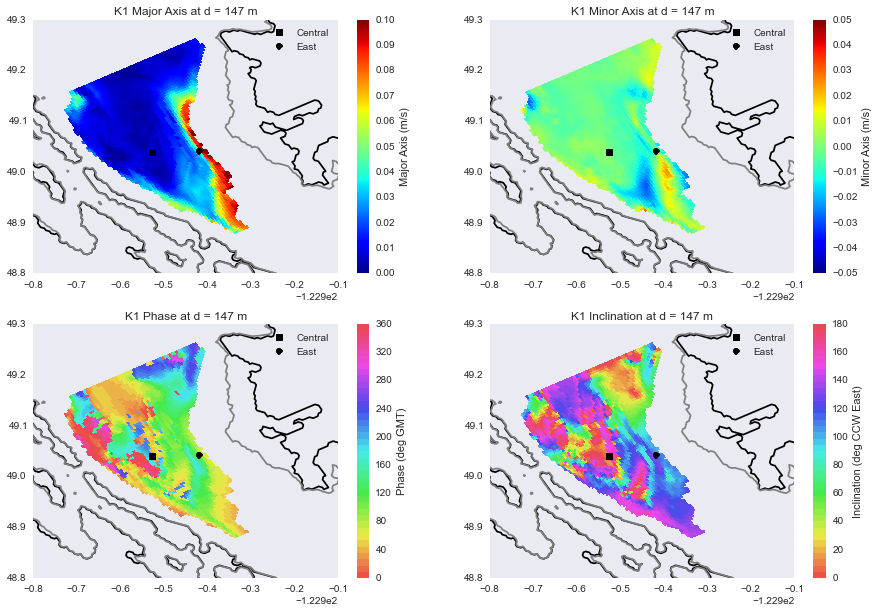

In [12]:
dep=28
fig = plot_ellipse_params(dep, 'K1', datastruc, maj_lim = [0,.1], min_lim = [-.05,.05])